# Unpack `gtfs-segments` underlying functions

**https://gtfs-segments.readthedocs.io/en/latest/**

At first glance, it looks like the `gtfs-segments` package does something similar to what we want for segments.


### Pros
1. Maintained package
1. Consolidate 2 scripts into just using this package
1. Can potentially cut segments faster than we can...maybe a performance gain
1. Can potentially cut `loop_or_inlining==1` shapes better
1. Looks like functions take any df or gdf, so there aren't any class dependencies, we may be able to lift exactly what we want

### Remaining Issues
**1. Check that they cut loopy shapes better?**
Yes!

**2. What identifier columns do they use?**
We can simply rename `trip_instance_key -> trip_id` and `shape_array_key -> shape_id`

**3. Do their segments run from prior stop to current stop?**
No, it runs from current stop to subsequent stop.

**4. How do they aggregate up beyond each trip? They use `route_id, direction_id, stop_id1, stop_id2`, but do they still cut it at the trip-level, or have they solved aggregation issue?**
They cut at the trip-level, and then do some suffix-appending at the route-level. They haven't solved the aggregation issue either.

In [1]:
import pandas as pd
import gtfs_segments

In [2]:
#sources_df = gtfs_segments.fetch_gtfs_source(place='MTS')
#gtfs_segments.download_latest_data(sources_df,'data')
#transit_path = 'data/San Francisco-San Francisco Municipal Transportation Agency (SFMTA, Muni)-CA/gtfs.zip'
transit_path = "data/San Diego-San Diego International Airport, Metropolitan Transit System (MTS)-CA/gtfs.zip"
transit_df = gtfs_segments.get_gtfs_segments(transit_path)

/opt/conda/lib/python3.9/site-packages/gtfs_segments/partridge_mod/gtfs.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,col] = converter(df.loc[:,col])


In [3]:
_, bus_feed = gtfs_segments.partridge_func.get_bus_feed(transit_path)

In [4]:
bus_feed

In [5]:
type(bus_feed)

gtfs_segments.partridge_mod.gtfs.Feed

In [6]:
bus_feed_df = gtfs_segments.process_feed(bus_feed)

/opt/conda/lib/python3.9/site-packages/gtfs_segments/partridge_mod/gtfs.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,col] = converter(df.loc[:,col])


In [7]:
bus_feed_df.head(3)

,segment_id,route_id,direction_id,trip_id,traversals,distance,stop_id1,stop_id2,geometry
0,10106-10111-1,1,0.0,17403779,50.0,169.70,10106,10111,"LINESTRING (-117.15548 32.74841, -117.15548 32..."
1,10111-10114-1,1,0.0,17403779,50.0,218.01,10111,10114,"LINESTRING (-117.15367 32.74849, -117.15367 32..."
2,10114-10494-1,1,0.0,17403779,50.0,225.73,10114,10494,"LINESTRING (-117.15134 32.74850, -117.15134 32..."


In [8]:
stop_feed_df = gtfs_segments.gtfs_segments.process_feed_stops(bus_feed)

Before we actually can use `gtfs_segments.create_segments`, we need to make sure our `stop_df` is set up the same way as theirs.

The first function within `create_segments` is `nearest_points`. 
* https://gtfs-segments.readthedocs.io/en/latest/gtfs_segments/#gtfs_segments.gtfs_segments.create_segments
* Looks like they rename the stop's point geometry to be `start`
* The other columns are generated but not used
* We can simply rename `trip_instance_key -> trip_id` and `shape_array_key -> shape_id`

In [9]:
stop_feed_df.head(3)

,shape_id,trip_id,stop_id,stop_sequence,start,geometry,route_id,service_id,direction_id,traversals,n_stops,distance,mean_distance
0,105_0_98,17285440,94028,1,POINT (-117.19929 32.75465),"LINESTRING (-117.19922 32.75467, -117.19920 32...",105,S2_81310-1111100-0,0.0,28.0,42,16644.763924,396.303903
1,105_0_99,17285515,94028,1,POINT (-117.19929 32.75465),"LINESTRING (-117.19922 32.75467, -117.19920 32...",105,S2_81310-1111100-0,0.0,4.0,29,10048.674379,346.506013
2,105_1_100,17285516,13192,1,POINT (-117.20595 32.82880),"LINESTRING (-117.20611 32.82881, -117.20611 32...",105,S2_81310-1111100-0,1.0,3.0,37,11561.849663,312.482423



1. Process shapes
```
shapes = ret_high_res_shape(feed.shapes, spat_res=5)
```

2. Merge shape to trips 
```
trip_df = merge_trip_geom(feed.trips, shapes)
trip_ids = set(trip_df.trip_id.unique())
stop_loc_df = feed.stops[["stop_id", "geometry"]]
```

3. Filter down stop times to trips that exist and merge in stop geometry
```
stop_df = filter_stop_df(feed.stop_times, trip_ids, stop_loc_df)
stop_df = merge_stop_geom(stop_df, stop_loc_df)
stop_df = stop_df.merge(trip_df, on="trip_id", how="left")
```

4. Create segments..the output of above should be what the output of `process_feed_stops` is

```
stop_df = create_segments(stop_df)
```

## Our already-cut segments

In [10]:
import geopandas as gpd

from segment_speed_utils import helpers
from segment_speed_utils.project_vars import SEGMENT_GCS, RT_SCHED_GCS
from shared_utils import rt_dates

analysis_date = rt_dates.DATES["nov2023"]

In [11]:
operators = helpers.import_scheduled_trips(
    analysis_date,
    columns = ["gtfs_dataset_key", "name"],
    get_pandas = True
)

In [12]:
subset_operators = operators[
    #(operators.name.str.contains("Muni")) | 
    (operators.name.str.contains("San Diego"))
].schedule_gtfs_dataset_key.unique()

In [13]:
sd_routes = helpers.import_scheduled_trips(
    analysis_date,
    columns = ["gtfs_dataset_key", "shape_array_key", "trip_id", 
               "route_id", "direction_id"],
    filters = [[("gtfs_dataset_key", "in", subset_operators)]],
    get_pandas = True
)

In [14]:
stop_segments = gpd.read_parquet(
    f"{SEGMENT_GCS}stop_segments_{analysis_date}.parquet",
    filters = [[("schedule_gtfs_dataset_key", "in", subset_operators)]]
).merge(
    sd_routes,
    on = ["schedule_gtfs_dataset_key", "shape_array_key"],
    how = "inner"
).rename(columns = {"seg_idx": "segment_id"})

### Set our input df

This more accurately reflects how we'd work the package into our workflow.

We would set up our own input df for all operators and then cut segments.

In [15]:
stop_times = helpers.import_scheduled_stop_times(
    analysis_date,
    columns = ["schedule_gtfs_dataset_key", "trip_instance_key",
               "shape_array_key",
               "stop_id", "stop_sequence", "geometry"],
    filters = [[("shape_array_key", "in", 
                 sd_routes.shape_array_key.unique())]],
    with_direction = True,
    get_pandas = True,
    crs = "EPSG:4326"
).merge(
    helpers.import_scheduled_trips(
        analysis_date,
        columns = ["trip_instance_key", "route_id", "direction_id"],
        filters = [[("shape_array_key", "in", 
                     sd_routes.shape_array_key.unique())]],
        get_pandas = True
    ),
    on = "trip_instance_key",
)

In [16]:
shapes = helpers.import_scheduled_shapes(
    analysis_date,
    columns = ["shape_array_key", "geometry"],
    filters = [[("shape_array_key", "in", 
                 sd_routes.shape_array_key.unique())]],
    crs = "EPSG:4326",
    get_pandas = True
).dropna(subset="geometry")
    
sd_df = pd.merge(
    stop_times.rename(columns = {"geometry": "start"}),
    shapes,
    on = "shape_array_key",
    how = "inner"
).rename(columns = {
    "trip_instance_key": "trip_id", 
    "shape_array_key": "shape_id",
}).dropna(subset="geometry").reset_index(drop=True)

In [17]:
#sd_segments = gtfs_segments.gtfs_segments.create_segments(sd_df)
#sd_segments.to_parquet("sd_segments.parquet")
sd_segments = gpd.read_parquet("sd_segments.parquet")

Excluding Trip: 5150a0b60554aef40061302368b455d8 because of failed snap!
Excluding Trip: 54b2a98c9875ce15902c3e7627908705 because of failed snap!
Excluding Trip: 9009eeb6e0fed56621cefb2fd625269e because of failed snap!
Excluding Trip: 9ef203b8e9db51be7615727f482a8fbb because of failed snap!
Excluding Trip: cdf90f2d67c7b34921d32a5f28af2d7a because of failed snap!
Excluding Trip: e04a3116a8d8b12eecf05115ca73cf66 because of failed snap!


In [18]:
routes_in_common = list(
    set(stop_segments[stop_segments.direction_id==0].route_id.unique()) &
    set(bus_feed_df[bus_feed_df.direction_id==0].route_id.unique()) & 
    set(sd_segments[sd_segments.direction_id==0].route_id.unique())
)

In [19]:
normal_routes = stop_segments[
    (stop_segments.loop_or_inlining==0) & 
    (stop_segments.route_id.isin(routes_in_common))
].drop_duplicates(subset="route_id").route_id.unique()

loopy_routes = stop_segments[
    (stop_segments.loop_or_inlining==1) & 
    (stop_segments.route_id.isin(routes_in_common))
].drop_duplicates(subset="route_id").route_id.unique()

print(f"# normal routes: {len(normal_routes)},  # loopy routes: {len(loopy_routes)}")

# normal routes: 82,  # loopy routes: 18


## Map Comparisons

In [20]:
def map_segments(
    gdf: gpd.GeoDataFrame, 
    one_trip: str, 
    title: str = "None"
):
    subset_df = gdf[gdf.route_id==one_trip]

    m = subset_df.plot(
        "segment_id", cmap="tab20", categorical=True, 
        legend = False, figsize=(2, 2)
    )
    
    m.set_title(title)
    m.set_facecolor("white")

    return m


AxesSubplot(0.125,0.276095;0.775x0.43781)
AxesSubplot(0.125,0.286892;0.775x0.416215)
AxesSubplot(0.125,0.207861;0.775x0.574278)
AxesSubplot(0.125,0.216799;0.775x0.556402)
AxesSubplot(0.443241,0.11;0.138519x0.77)
AxesSubplot(0.433702,0.11;0.157596x0.77)
AxesSubplot(0.125,0.222362;0.775x0.545275)
AxesSubplot(0.125,0.236181;0.775x0.517638)
AxesSubplot(0.125,0.385744;0.775x0.218512)
AxesSubplot(0.125,0.396313;0.775x0.197374)
AxesSubplot(0.125,0.318456;0.775x0.353088)
AxesSubplot(0.125,0.324016;0.775x0.341969)
AxesSubplot(0.266615,0.11;0.49177x0.77)
AxesSubplot(0.251102,0.11;0.522796x0.77)
AxesSubplot(0.249638,0.11;0.525724x0.77)
AxesSubplot(0.266663,0.11;0.491675x0.77)
AxesSubplot(0.439501,0.11;0.145998x0.77)
AxesSubplot(0.439181,0.11;0.146638x0.77)
AxesSubplot(0.295653,0.11;0.433694x0.77)
AxesSubplot(0.306471,0.11;0.412058x0.77)


/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:684: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


AxesSubplot(0.18366,0.11;0.65768x0.77)
AxesSubplot(0.205149,0.11;0.614703x0.77)
AxesSubplot(0.27327,0.11;0.478459x0.77)
AxesSubplot(0.282239,0.11;0.460523x0.77)
AxesSubplot(0.210749,0.11;0.603503x0.77)
AxesSubplot(0.225696,0.11;0.573608x0.77)
AxesSubplot(0.125,0.157095;0.775x0.67581)
AxesSubplot(0.125,0.168448;0.775x0.653103)
AxesSubplot(0.125,0.232854;0.775x0.524293)
AxesSubplot(0.125,0.221737;0.775x0.546525)
AxesSubplot(0.125,0.330399;0.775x0.329202)
AxesSubplot(0.125,0.342904;0.775x0.304192)
AxesSubplot(0.125,0.442509;0.775x0.104981)
AxesSubplot(0.125,0.447809;0.775x0.0943825)
AxesSubplot(0.125,0.323344;0.775x0.343311)
AxesSubplot(0.125,0.318955;0.775x0.352091)
AxesSubplot(0.125,0.409631;0.775x0.170737)
AxesSubplot(0.125,0.414408;0.775x0.161184)
AxesSubplot(0.125,0.241015;0.775x0.50797)
AxesSubplot(0.125,0.254348;0.775x0.481304)
AxesSubplot(0.125,0.186969;0.775x0.616062)
AxesSubplot(0.125,0.166838;0.775x0.656324)
AxesSubplot(0.439459,0.11;0.146082x0.77)
AxesSubplot(0.42998,0.11;0.16

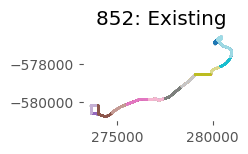

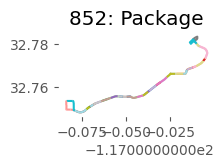

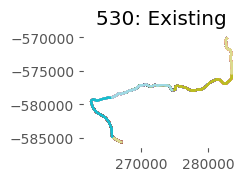

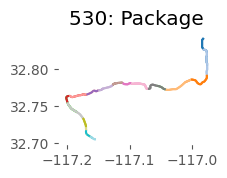

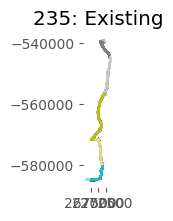

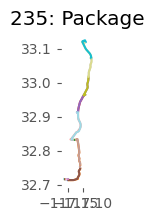

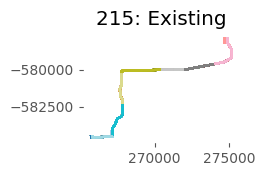

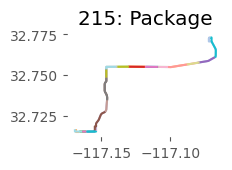

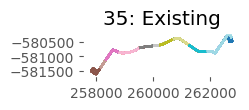

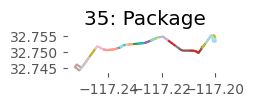

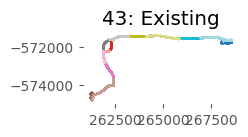

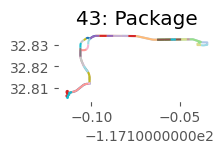

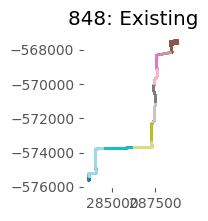

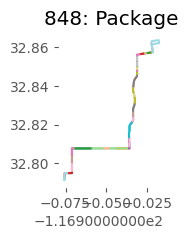

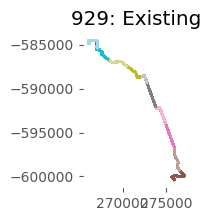

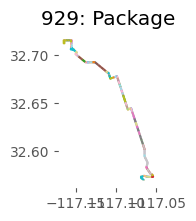

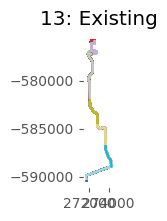

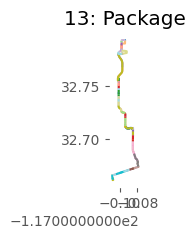

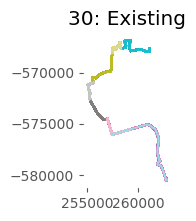

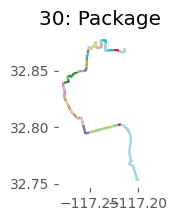

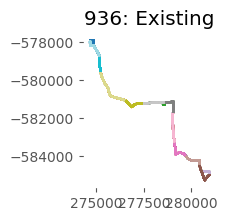

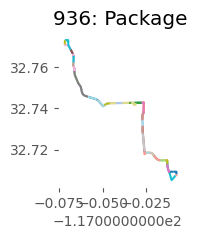

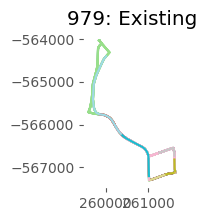

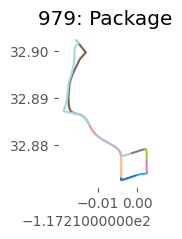

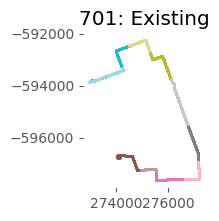

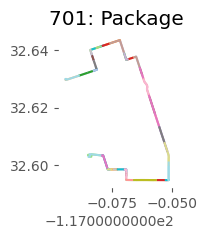

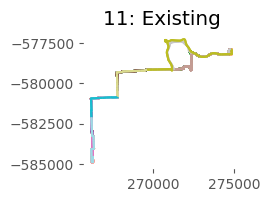

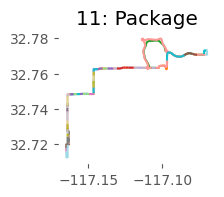

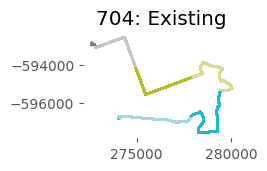

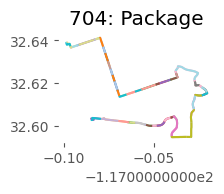

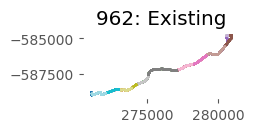

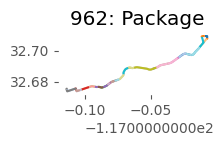

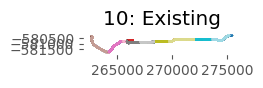

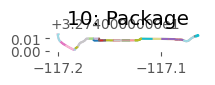

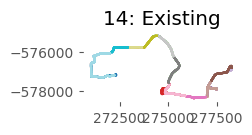

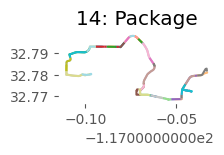

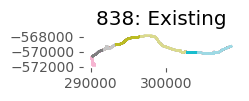

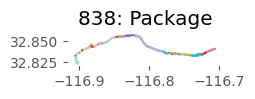

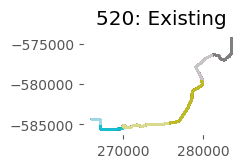

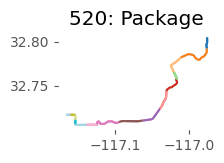

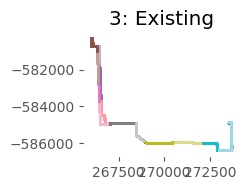

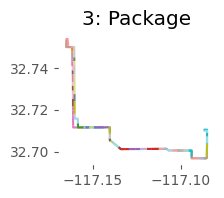

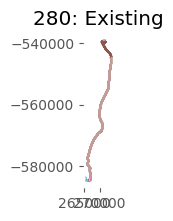

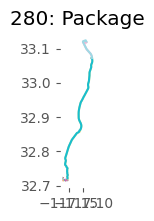

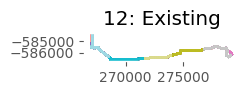

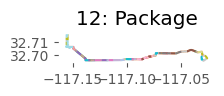

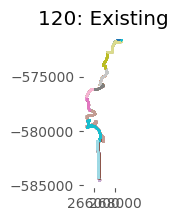

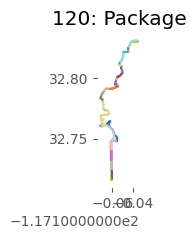

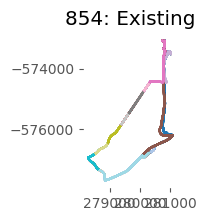

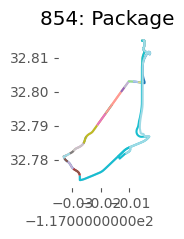

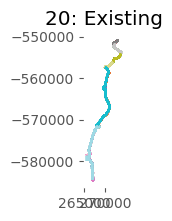

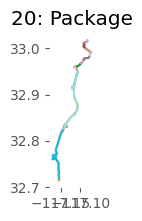

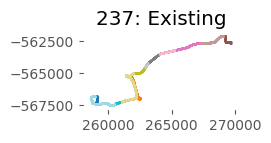

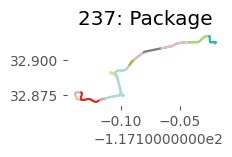

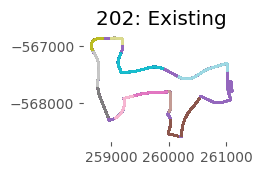

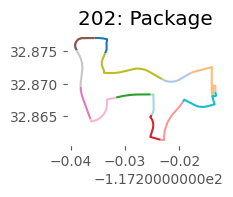

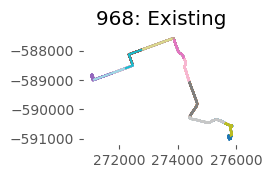

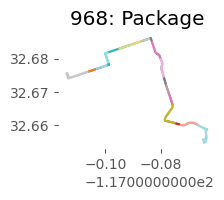

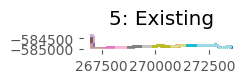

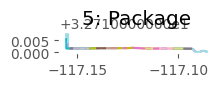

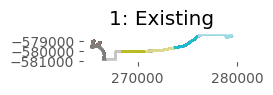

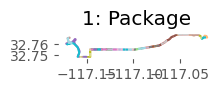

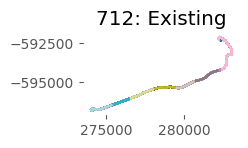

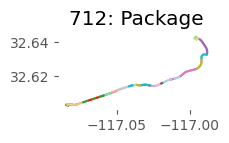

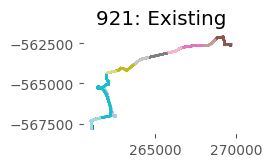

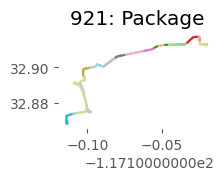

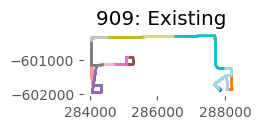

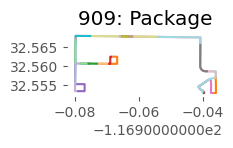

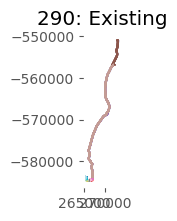

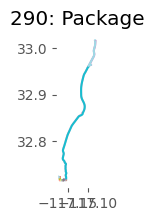

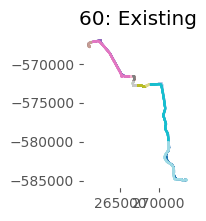

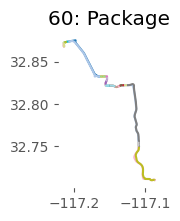

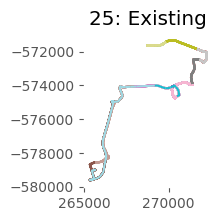

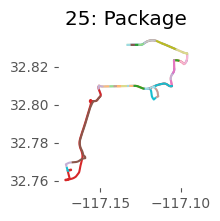

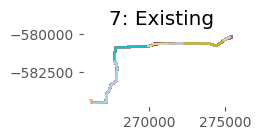

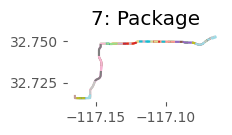

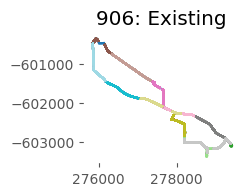

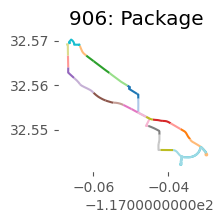

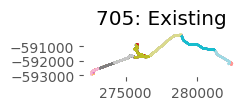

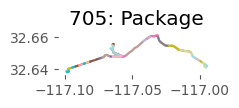

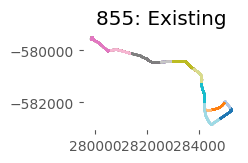

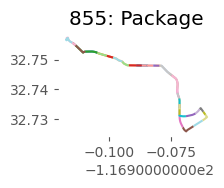

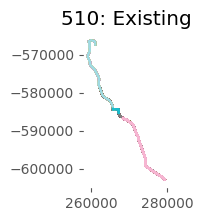

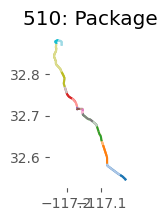

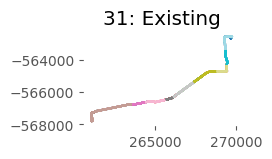

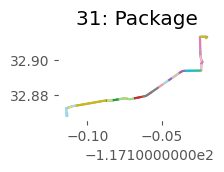

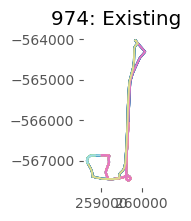

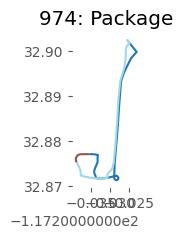

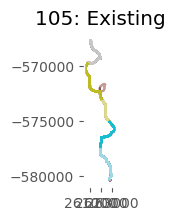

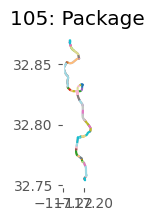

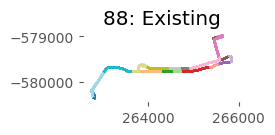

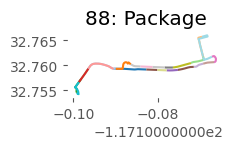

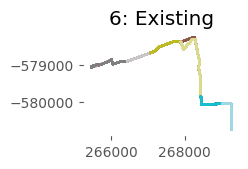

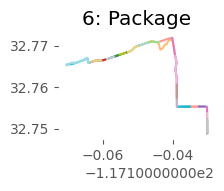

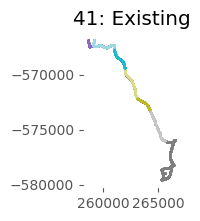

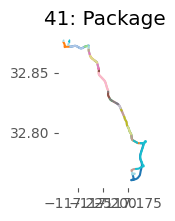

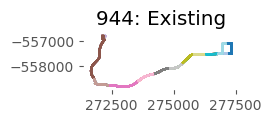

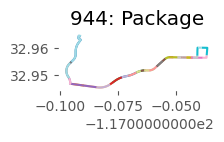

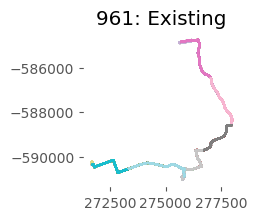

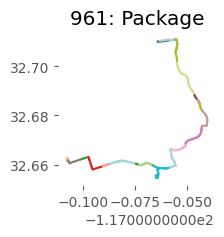

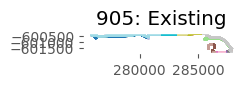

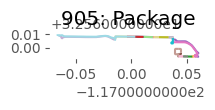

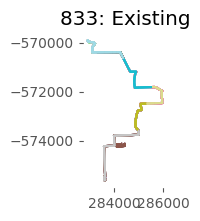

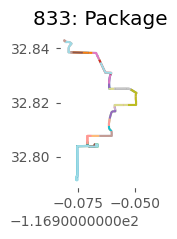

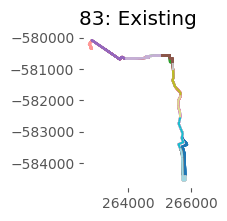

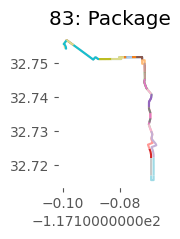

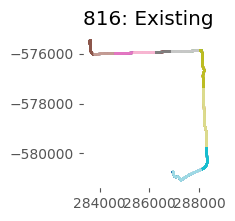

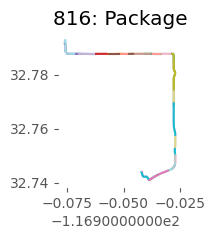

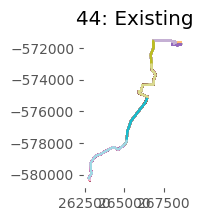

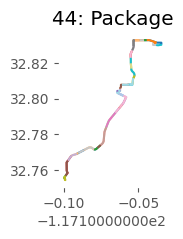

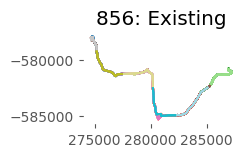

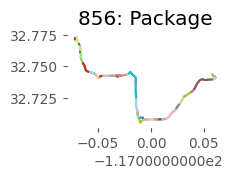

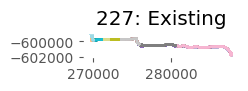

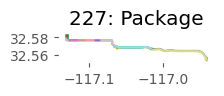

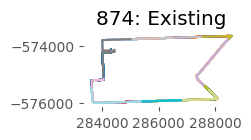

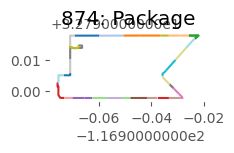

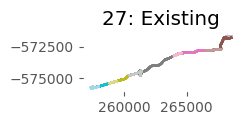

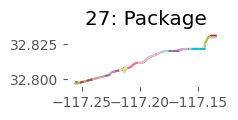

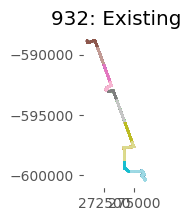

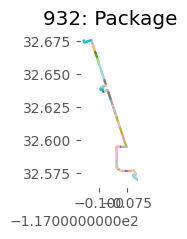

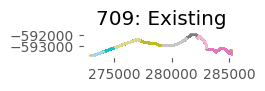

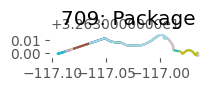

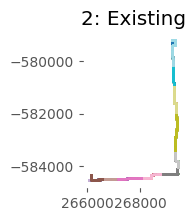

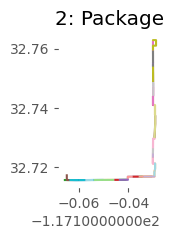

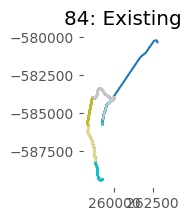

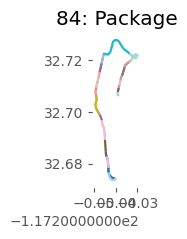

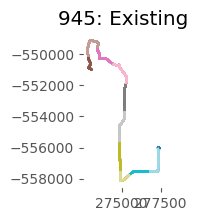

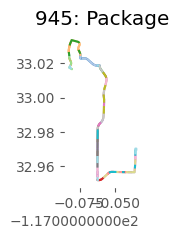

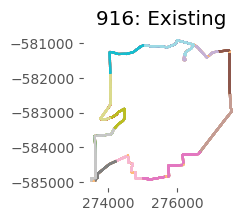

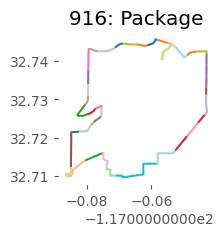

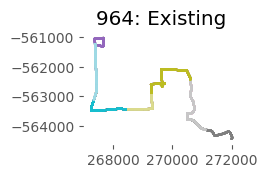

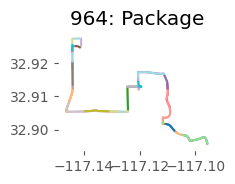

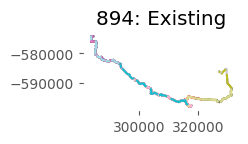

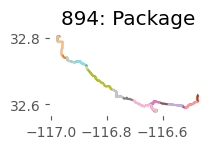

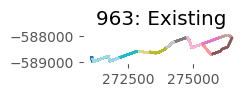

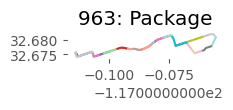

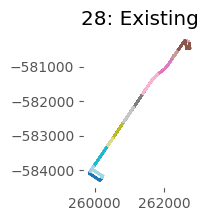

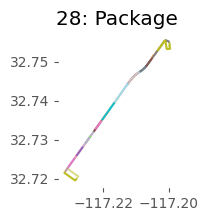

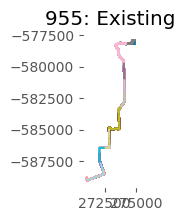

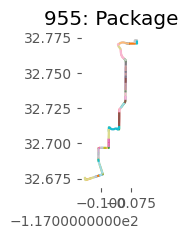

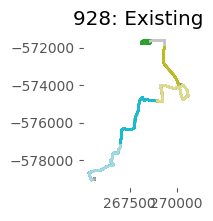

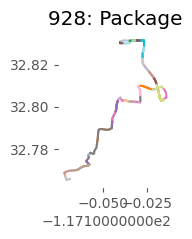

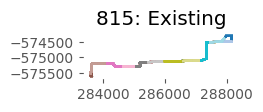

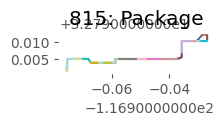

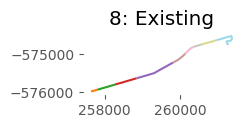

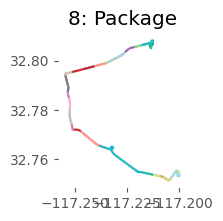

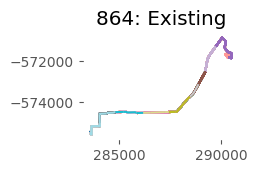

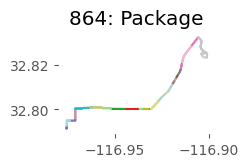

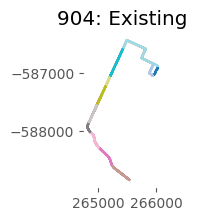

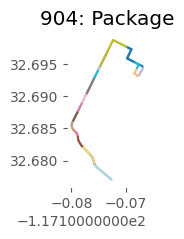

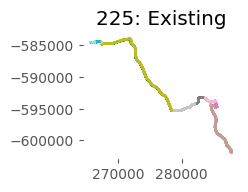

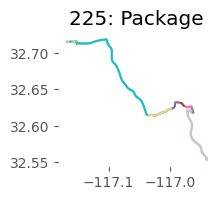

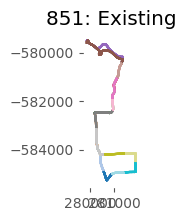

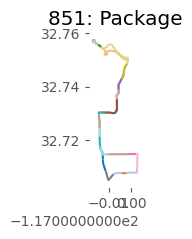

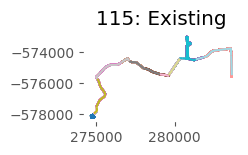

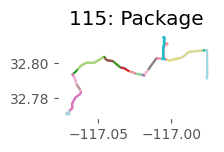

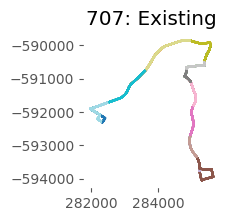

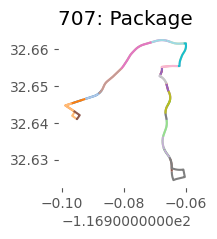

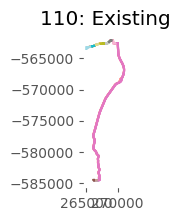

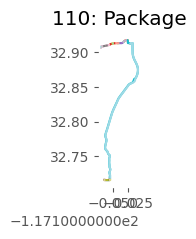

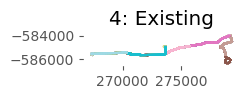

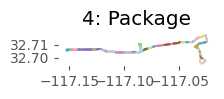

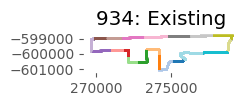

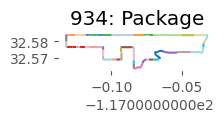

In [21]:
for i in normal_routes:
    my_segments = map_segments(
        stop_segments, i,  
        title=f"{i}: Existing")
    
    print(my_segments)
    
    pkg_segments = map_segments(
        bus_feed_df, i,  
        title=f"{i}: Package")
    
    print(pkg_segments)


AxesSubplot(0.125,0.318682;0.775x0.352635)
AxesSubplot(0.125,0.32182;0.775x0.34636)
AxesSubplot(0.323845,0.11;0.37731x0.77)
AxesSubplot(0.323306,0.11;0.378387x0.77)
AxesSubplot(0.125,0.310535;0.775x0.368929)
AxesSubplot(0.125,0.323249;0.775x0.343502)
AxesSubplot(0.23924,0.11;0.54652x0.77)
AxesSubplot(0.231208,0.11;0.562585x0.77)
AxesSubplot(0.352746,0.11;0.319508x0.77)
AxesSubplot(0.344971,0.11;0.335059x0.77)
AxesSubplot(0.125,0.150899;0.775x0.688201)
AxesSubplot(0.125,0.142945;0.775x0.70411)
AxesSubplot(0.125,0.414909;0.775x0.160181)
AxesSubplot(0.125,0.414768;0.775x0.160465)
AxesSubplot(0.314846,0.11;0.395308x0.77)
AxesSubplot(0.318808,0.11;0.387384x0.77)
AxesSubplot(0.125,0.32925;0.775x0.331499)
AxesSubplot(0.125,0.332113;0.775x0.325775)
AxesSubplot(0.125,0.385265;0.775x0.21947)
AxesSubplot(0.125,0.392282;0.775x0.205435)


/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:684: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


AxesSubplot(0.125,0.170818;0.775x0.648363)
AxesSubplot(0.125,0.150532;0.775x0.688936)
AxesSubplot(0.125,0.443739;0.775x0.102522)
AxesSubplot(0.125,0.431971;0.775x0.126059)
AxesSubplot(0.126273,0.11;0.772455x0.77)
AxesSubplot(0.125,0.115681;0.775x0.758637)
AxesSubplot(0.125,0.34746;0.775x0.29508)
AxesSubplot(0.125,0.355481;0.775x0.279039)
AxesSubplot(0.125,0.274119;0.775x0.441762)
AxesSubplot(0.125,0.282577;0.775x0.424847)
AxesSubplot(0.27327,0.11;0.478459x0.77)
AxesSubplot(0.282239,0.11;0.460523x0.77)
AxesSubplot(0.125,0.224524;0.775x0.540952)
AxesSubplot(0.125,0.214457;0.775x0.561085)
AxesSubplot(0.125,0.300711;0.775x0.388578)
AxesSubplot(0.125,0.287652;0.775x0.414696)


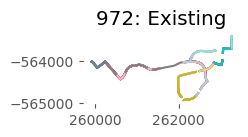

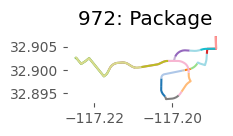

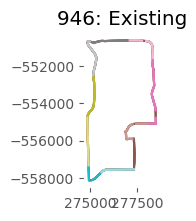

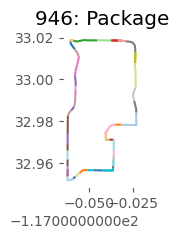

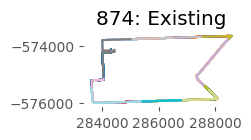

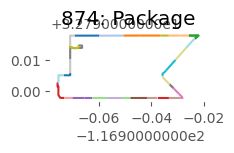

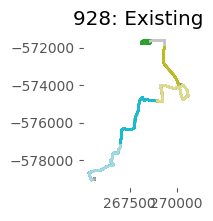

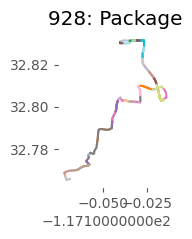

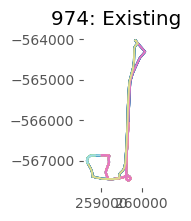

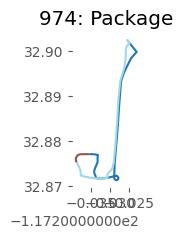

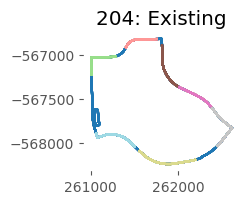

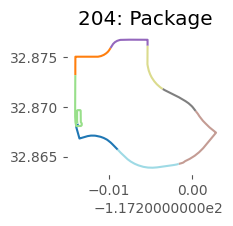

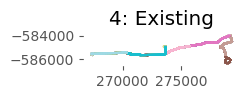

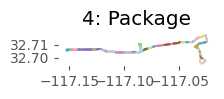

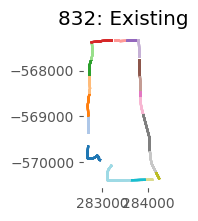

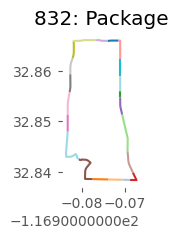

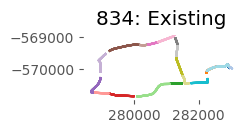

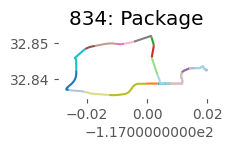

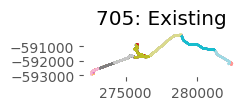

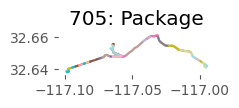

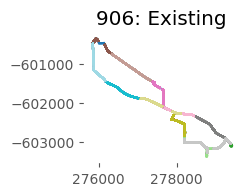

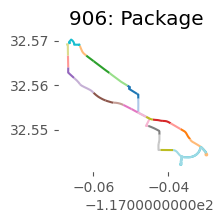

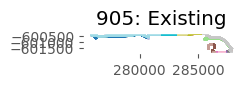

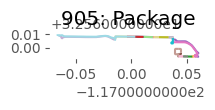

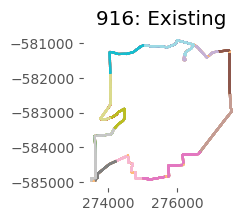

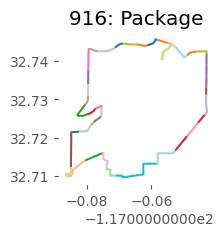

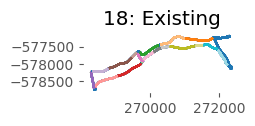

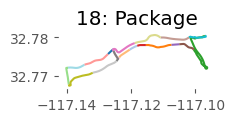

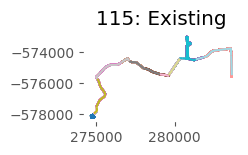

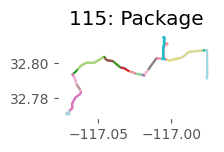

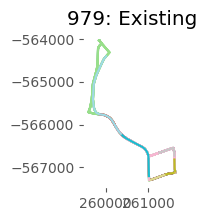

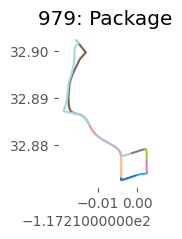

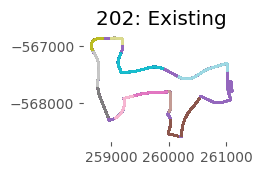

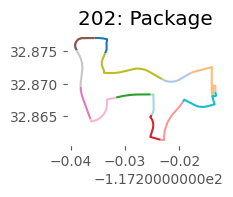

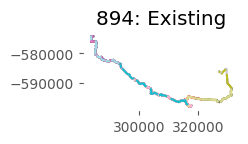

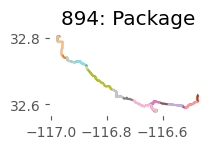

In [22]:
for i in loopy_routes:
    
    my_segments = map_segments(
        stop_segments, i, 
        title=f"{i}: Existing")
    
    print(my_segments)
    
    pkg_segments = map_segments(
        bus_feed_df, i, 
        title=f"{i}: Package")
    
    print(pkg_segments)
    